# 第12回 機械学習入門3 決定木

決定木は回帰と分類の両方に適用できるアルゴリズムである。CART（Classification and Regression Tree）と呼ばれる、それぞれのノードが2つの子ノードのみを持つ（二分木）アルゴリズムを紹介する。

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## CART


### 決定木による分類（分類木）

アヤメのデータを用いてCARTアルゴリズムによる予測を実行してみる。scikit-learnの`DecisionTreeClassifier`クラスを用いる。DecisionTreeClassifierについては以下を参照：
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

データはscikit-learnライブラリから読み込む。

In [2]:
# このセルを実行すれば、`Xi_np`に特徴量、`yi_np`に正解が代入される。
from sklearn.datasets import load_iris
iris = load_iris()
Xi_np = iris.data
yi_np = iris.target

訓練データとテストデータに分割。

In [3]:
Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi_np, yi_np, random_state=123)

決定木では特徴量のスケーリングは不要である。

`DecisionTreeClassifier`クラスをインポート


In [4]:
from sklearn.tree import DecisionTreeClassifier

決定木による予測を行う。`max_depth`オプションで決定木の深さを指定する。

In [5]:
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(Xi_train, yi_train)

DecisionTreeClassifier(max_depth=2)

スコアを計算する。

In [6]:
print(clf.score(Xi_test, yi_test))
print(clf.score(Xi_train, yi_train))

0.9473684210526315
0.9642857142857143


決定木を図示する。`plot_tree`メソッドを使う。
https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html

In [7]:
from sklearn.tree import plot_tree

特徴量と正解の名称を見ておく。

In [8]:
print(iris.feature_names)
print(iris.target_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


決定木の図示。

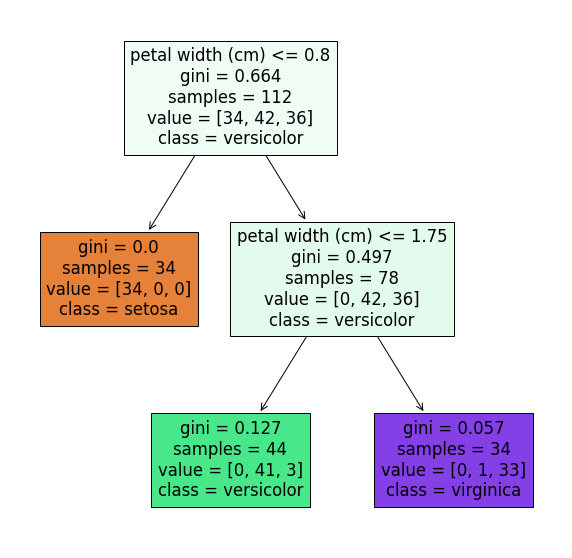

In [9]:
plt.figure(figsize=(10, 10))
plot_tree(clf, feature_names=iris.feature_names, class_names=iris.target_names, filled=True)
plt.show()

### CARTアルゴリズム

決定木は特徴量の空間を軸に平行な境界のみにより分割し予測を行うアルゴリズムである。

[特徴量空間と決定境界の図を挿入]

厳密には以下のように定義される。まず、$R_i$（$i=1,\dots,J$）を特徴量空間の互いに交わらない集合とする。このとき、以下のモデルを決定木という。

$$
T(x; \Theta) = \sum_{j=1}^J\gamma_j I(x \in R_j)
$$

ここで、$\Theta=\{R_j, \gamma_j\}_{j=1,\dots,J}$はパラメータであり、$J$は領域の数を表すハイパーパラメータである。このように定義したとき、何らかの損失関数$L(y, \hat{y})$に対して

$$
\sum_{j=1}^J\sum_{x_i \in R_j}L(y_i, \gamma_i)
$$

を最小にするパラメータ$R_j, \gamma_j$を求めればよい。
（例えば、回帰の場合$L(y, \hat{y}) = (y - \hat{y})^2$）
一般にこの最小化問題を解くことは難しいため、以下のように順次特徴量空間を分割するアルゴリズムを採用する。

一番上のノードからスタートし、順次子ノードを2つ作っていく。
各ノードにおいて、どのような基準で2つの子ノードを作るかがポイントとなる。
各ノードにおいては、適切な特徴量$X$としきい値$t$を選ぶことができれば、
$X \leq t$を満たすデータとそれ以外（$X > t$）のデータに分けて子ノードを作ることができる。
では、適切な$X$と$t$をどのように選べばよいか？

まず、ノードの**不純度**を定義する。
不純度は各ノードにおけるデータのクラスの「混じり気」の大きさを表す指標である。
ノードに1つのクラスのデータしか含まれない場合は、不純度は0となり（例えば、上図の上から2段め左（オレンジ色）のノード）、各クラスが同じ数含まれるノードの不純度は最大となる。
`DecisionTreeClassifier`クラスではデフォルトで**Gini不純度**により、不純度が計算される。Gini不純度の定義は以下である。

$$
G = 1 - \sum_{k=1}^Kp_k^2
$$

ここで、$K$はクラスの数、$p_k$はそのノードに含まれるデータに占めるクラス$k$のデータの割合。エントロピーと呼ばれる不純度が使われるときもある。

いま、あるノードの不純度を$G_{\text{parent}}$、その左子ノード、右子ノードの不純度をそれぞれ、$G_{\text{letf}}$, $G_{\text{right}}$と置く。また、ノードに含まれるデータ数を$m$、左子ノード、右子ノードに含まれるデータ数をそれぞれ $m_{\text{left}}$, $m_{\text{right}}$としたとき、
不純度の減少分

$$
G_{\text{parent}} - 
\left(\frac{m_{\text{left}}}{m}G_{\text{left}} 
+ \frac{m_{\text{right}}}{m}G_{\text{right}}\right)
$$

が最大になるように特徴量$X$としきい値$t$を決定する。

こうして、一定の深さを持つ決定木が構成されたとする。
新たな特徴量に対しクラスを予測するには、その特徴量に決定木を適用して、最後に含まれる**葉ノード**（子ノードのないノード）において、もっとも多数を占めるデータのクラスがその特徴量に対するクラスの予測値となる。
たとえば、上図において、上から3段目右ノード（紫色のノード）には、
setosaが0, versicolorが1, virginicaが31なのでvirginicaと予測する。

決定木の深さ `max_depth` はあらかじめ指定する必要のあるハイパーパラメータである。決定木の深さを非常に大きくすれば、訓練データに対する当てはまりが100%の決定木を作ることはできるが、過学習が起きる可能性が高い。過学習を防ぐように深さを決定する必要がある。







### 決定木による回帰（回帰木）

回帰に対しても分類とほぼ同様にCARTアルゴリズムが適用できる。
ノードの分割を決定する際、不純度の代わりに、平均二乗誤差

$$
\text{MSE}
= \frac{1}{N}\sum_{i}(y_i - \bar{y})^2
$$

を用いればよい。ここで、$N$はそのノードに含まれるデータ数、$\sum_{i}$はそのノードに含まれるすべてのデータについて和を取ることを意味する。
$\text{MSE}$はそのノードに含まれるデータの正解$\{y_i\}$の分散に他ならない。

あとは、分類木と同様に、平均二乗誤差の減少分

$$
\text{MSE}_{\text{parent}} 
- \left(\frac{m_{\text{left}}}{m}\text{MSE}_{\text{left}}+\frac{m_{\text{right}}}{m}\text{MSE}_{\text{right}}\right)
$$

が最大になるように、特徴量$X$としきい値$t$を選べばよい。


scikit-learnのDecisionTreeRegressorクラス（https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html） により回帰木を実行できる。
例としてボストン住宅価格データを使う。


In [ ]:
# このセルを実行すれば、`Xb_np`に特徴量、`yb_np`に正解が代入される。
from sklearn.datasets import load_boston
boston = load_boston()
Xb_np = boston.data
yb_np = boston.target

訓練データとテストデータに分割する。

In [11]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb_np, yb_np, random_state=123)

`DecisionTreeRegressor`クラスのインポート

In [12]:
from sklearn.tree import DecisionTreeRegressor

回帰木の構築

In [13]:
reg = DecisionTreeRegressor(max_depth=2)
reg.fit(Xb_train, yb_train)

DecisionTreeRegressor(max_depth=2)

スコアの計算

In [14]:
print(reg.score(Xb_test, yb_test))
print(reg.score(Xb_train, yb_train))

0.5564791971697227
0.7325690523735464


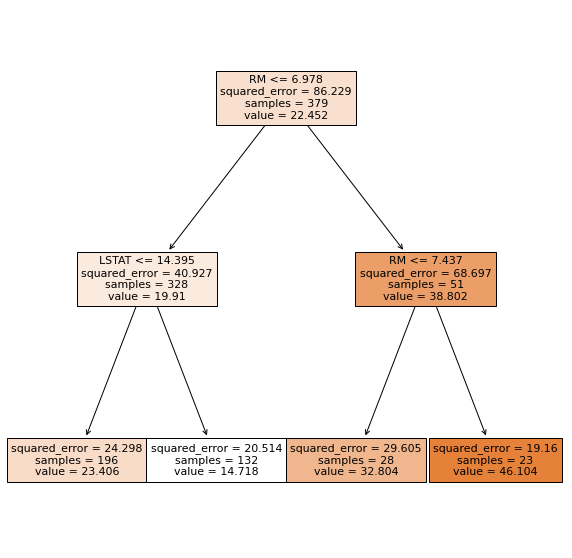

In [15]:
plt.figure(figsize=(10, 10))
plot_tree(reg, feature_names=boston.feature_names, filled=True)
plt.show()

In [16]:
print(reg.feature_importances_)
print(boston.feature_names)

[0.         0.         0.         0.         0.         0.75131531
 0.         0.         0.         0.         0.         0.
 0.24868469]
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


## アンサンブル学習

複数の機械学習モデル（予測器と呼ぶ）を組み合わせることで、精度の良い予測をしようとする手法を**アンサンブル法**という。

1つ1つの予測器の精度が低くても、それらの予測器から予測された結果の多数決を取ることでより精度の良い予測をすることができる。
たとえば、分類問題において51%の正解率をもつ予測器が1000個あったとする。
これらの予測器の多数決により正解を予測するとすれば、正解率はいくつになるだろうか。


In [17]:
from scipy.special import comb
import math

p = 0.6  # 1つの予測器の正解率
N = 100  # 予測器の数
m = math.floor(N / 2 + 1)
prob = np.zeros(N - m + 1)
i = 0
for k in range(m, N + 1):
  prob[i] = comb(N, k) * p**k * (1 - p)**(N - k)
  i += 1
print(sum(prob))

0.972900802242991


正解率は約72%になる。ただし、この計算からも分かるように、各予測器の判断は**独立でなくてはならない**。

ここでは、ランダムフォレストと勾配ブースティング決定木を取り上げる。

### ランダムフォレスト

少しずつ異なる決定木をランダムに複数作り、その多数決により予測をする手法を**ランダムフォレスト**とよぶ。ランダムフォレストでは通常の決定木アルゴリズムと下記の点が異なる。

- 訓練データから重複を許してデータをランダムに抽出し（ブートストラップ標本を作るという）、新たな訓練データとして使う。
- 各ノードにおいて、特徴量をランダムに非復元抽出し、抽出された特徴量により子ノードを作る。（決定木の場合と異なり、一部の特徴量を使って子ノードを作る）

以上により、複数の決定木を生成し、予測の場合は多数決により、回帰の場合は予測値の平均により、予測を行う。

scikit-learnでは、分類については RandamForestClassifier、回帰については RandomForestRegressor クラスによりランダムフォレストを実行できる。

RandomForestClassifireクラス
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

RandomForestRegressorクラス
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

アヤメデータをランダムフォレストにかけてみる。

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
clfr = RandomForestClassifier(n_estimators=1000, max_depth=2, max_features='sqrt')
clfr.fit(Xi_train, yi_train)

RandomForestClassifier(max_depth=2, max_features='sqrt', n_estimators=1000)

In [20]:
print(clfr.score(Xi_test, yi_test))
print(clfr.score(Xi_train, yi_train))

0.9473684210526315
0.9642857142857143


ランダムフォレストを図示することはできない。

**演習問題**
ボストン住宅価格データを `RandomForestRegressor` により予測してみよ。

### 勾配ブースティング決定木

勾配ブースティング決定木では、予測器を逐次的に生成していく。
その際、1つ前の決定木の残差（正解と予測値の差）を次の決定木が修正するように、決定木を順番に生成する。大雑把には

$$
(m+1)\text{番目の決定木} = m\text{番目の決定木} + \text{学習率} \times (m\text{番目の決定木の残差を予測する決定木})
$$

となる。$(m\text{番目の決定木の残差を予測する決定木})$の部分が損失関数の勾配になるので、勾配ブースティングと呼ばれる。実際、数学的に表現をすると勾配降下法に似たアルゴリズムになる。


scikit-learnでは勾配ブースティング回帰木についてはGradientBoostingRegressorクラス、勾配ブースティング分類木については
GradientBoostingClassifierクラスを使えばよい。

GradientBoostingRegressorクラス
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

GradientBoostingClassifierクラス
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

ボストン住宅価格データに`GradientBoostingRegressor`を適用してみる。

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

In [26]:
greg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2)
greg.fit(Xb_train, yb_train)

GradientBoostingRegressor(max_depth=2)

In [27]:
print(greg.score(Xb_test, yb_test))
print(greg.score(Xb_train, yb_train))

0.839508802061916
0.9545303769358543


**演習問題** アヤメデータに勾配ブースティング分類木を適用してみよ。


## 参考: グリッドサーチ

ハイパーパラメータを手動で調整して、良いスコアを探すのは大変。scikit-learnでは`GridSearchCV`クラスにより**グリッドサーチ**（自動的に最適なハイパーパラメータを探す）を行うことができる。
`GridSearchCV`については以下を参照
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

`GridSearchCV`は最適なハイパーパラメータを交差検証により探す。ランダムフォレストによるボストン住宅価格データの予測を例に、`GridSearchCV`を使ってみる。


In [28]:
from sklearn.model_selection import GridSearchCV

探索するランダムフォレストのハイパーパラメータ `n_estimators`と`max_depth`の集合を定義する。ディクショナリの形式で記述する。

In [29]:
param_grid = {'n_estimators': [10, 100, 1000],
              'max_depth': [7, 8, 9, 10]}

In [30]:
grid_search = GridSearchCV(greg, param_grid, cv=5, scoring='r2')
grid_search.fit(Xb_train, yb_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(max_depth=2),
             param_grid={'max_depth': [7, 8, 9, 10],
                         'n_estimators': [10, 100, 1000]},
             scoring='r2')

In [31]:
grid_search.best_params_

{'max_depth': 7, 'n_estimators': 1000}

In [32]:
grid_search.best_score_

0.8080095731186361

スケーリングをする必要がある場合は、パイプラインを使うなど工夫が必要になる。